# Binary classification models

In [1]:
# Standard library imports
from typing import Tuple

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from tensorflow import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Fix Tensorflow's global random seed
random.set_seed(315)

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)
data_df.head()

incidents  year     month_sin  month_cos  AL  AR  AS  AZ  \
year state month                                                             
1953 AK    10             0  1953 -8.660254e-01   0.500000   0   0   0   0   
           11             0  1953 -5.000000e-01   0.866025   0   0   0   0   
           12             0  1953 -2.449294e-16   1.000000   0   0   0   0   
1954 AK    1              0  1954  5.000000e-01   0.866025   0   0   0   0   
           2              0  1954  8.660254e-01   0.500000   0   0   0   0   

                  CA  CO  ...  TN  TX  UT  VA  VI  VT  WA  WI  WV  WY  
year state month          ...                                          
1953 AK    10      0   0  ...   0   0   0   0   0   0   0   0   0   0  
           11      0   0  ...   0   0   0   0   0   0   0   0   0   0  
           12      0   0  ...   0   0   0   0   0   0   0   0   0   0  
1954 AK    1       0   0  ...   0   0   0   0   0   0   0   0   0   0  
           2       0   0  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 62 columns]

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43639 entries, (1953, 'AK', 10) to (2020, 'WY', 9)
Data columns (total 62 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   incidents  43639 non-null  int64  
 1   year       43639 non-null  int64  
 2   month_sin  43639 non-null  float64
 3   month_cos  43639 non-null  float64
 4   AL         43639 non-null  int64  
 5   AR         43639 non-null  int64  
 6   AS         43639 non-null  int64  
 7   AZ         43639 non-null  int64  
 8   CA         43639 non-null  int64  
 9   CO         43639 non-null  int64  
 10  CT         43639 non-null  int64  
 11  DC         43639 non-null  int64  
 12  DE         43639 non-null  int64  
 13  FL         43639 non-null  int64  
 14  FM         43639 non-null  int64  
 15  GA         43639 non-null  int64  
 16  GU         43639 non-null  int64  
 17  HI         43639 non-null  int64  
 18  IA         43639 non-null  int64  
 19  ID         43639 non-

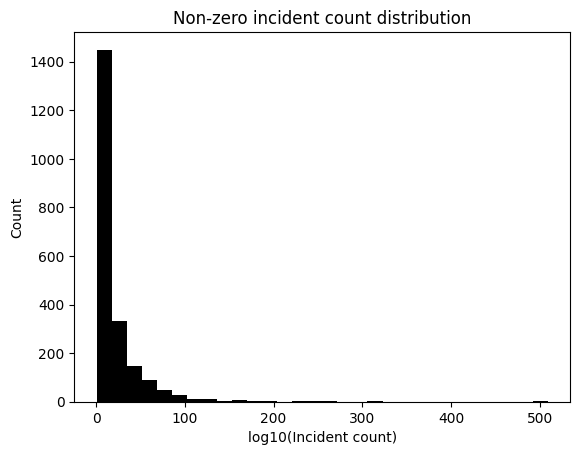

In [4]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Non-zero incident count distribution')
plt.hist(data_df['incidents'][data_df['incidents'] != 0], bins=30, color='black')
plt.xlabel('log10(Incident count)')
plt.ylabel('Count')
plt.show()

In [ ]:
total_disaster_months=len(data_df[data_df['incidents'] != 0])
percent_disaster_months=(total_disaster_months/len(data_df)) * 100
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) disaster months')

### 2.3. Batch data

In [6]:
def generate_data(data_df: pd.DataFrame, input_window: int) -> Tuple[np.array, np.array]:
    '''Takes dataframe, input window size, parses data into feature label pairs,
    returns as tuple of numpy arrays'''

    # Get list of states
    states=data_df.index.get_level_values('State').unique().tolist()

    features=[]
    labels=[]

    # Loop on states
    for state in states:

        # Extract the data for this state
        state_df=data_df.loc[:,state,:]

        # Indexing variable for batch
        input_start_index=0

        # Loop on the state data
        while input_start_index + input_window + 1 < len(state_df):

            # Extract and collect the features
            feature_row=state_df.iloc[input_start_index:input_start_index + input_window, :]
            features.append(feature_row.values.tolist())

            # Extract and collect the labels
            label=state_df.iloc[input_start_index + input_window, 0]

            # Binarize the label
            if label == 0:
                labels.append(0)
            else:
                labels.append(1)

            # Update the index
            input_start_index+=1

    # Convert to numpy arrays
    features=np.array(features)
    labels=np.array(labels)

    # Squeeze out the extra dimension for window width of 1
    if input_window == 1:
        features=features.squeeze(axis=1)

    return features, labels

In [ ]:
# Generate some feature, label pairs
input_window=1
features, labels=generate_data(data_df, input_window)

### 2.4. Train-test split

In [ ]:
# Split features and labels into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(features, labels)

print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')

# Draw a quick plot to check the distribution of disaster counts
training_disaster_counts=training_features[:,0].flatten()
nonzero_training_disaster_counts=training_disaster_counts[np.nonzero(training_disaster_counts)]

plt.title('Non-zero training data incident count distribution')
plt.hist(nonzero_training_disaster_counts, bins=30, color='black')
plt.xlabel('Incident count')
plt.ylabel('Count')
plt.show()

### 2.5. Transform with inverse hyperbolic tangent

In [ ]:
training_features[:,0]=np.arcsinh(training_features[:,0])
testing_features[:,0]=np.arcsinh(testing_features[:,0])

# Draw a quick plot to check the distribution of disaster counts
training_disaster_counts=training_features[:,0].flatten()
nonzero_training_disaster_counts=training_disaster_counts[np.nonzero(training_disaster_counts)]

plt.title('Training data incident count distribution')
plt.hist(nonzero_training_disaster_counts, bins=30, color='black')
plt.xlabel('Incident count')
plt.ylabel('Count')
plt.show()

### 2.5. Standardize features

In [ ]:
# Standardize the data
scaler=StandardScaler()
scaler.fit(training_features)
training_features=scaler.transform(training_features)
testing_features=scaler.transform(testing_features)

# Draw a quick plot to check the distribution of disaster counts
training_disaster_counts=training_features[:,0].flatten()
trimmed_training_disaster_counts=training_disaster_counts[training_disaster_counts > 0]

plt.title('Trimmed training data incident count distribution')
plt.hist(trimmed_training_disaster_counts, bins=30, color='black')
plt.xlabel('Incident count')
plt.ylabel('Count')
plt.show()

## 3. Logistic regression model

### 3.1. Fit the model on the training data

In [16]:
model=LogisticRegression(
    class_weight='balanced',
    random_state=315,
    max_iter=10000
).fit(training_features, training_labels)

### 3.2. Evaluate the model on the test data

In [ ]:
predictions=model.predict(testing_features)

precision=precision_score(testing_labels, predictions)
recall=recall_score(testing_labels, predictions)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

cm=confusion_matrix(testing_labels, predictions, normalize='all')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no incident', 'incident'])
_=cm_disp.plot()

OK, we have 0.017 false negative rate, which means we are missing some disasters, and a 0.36 false positive rate - that's a lot of false alarms! Let's try a better model.

## 4. LSTM model

### 4.1. Model definition function

In [18]:
# Helper function to build model
def build_lstm(training_features: np.array, learning_rate: float=0.00005) -> keras.models.Sequential:
    '''Builds and compiles LSTM model'''

    # Define and adapt a normalization layer.
    norm_layer=keras.layers.Normalization()
    norm_layer.adapt(training_features)

    # Define the model
    model=Sequential()
    model.add(layers.Input((training_features.shape[1],training_features.shape[2])))
    model.add(norm_layer)
    model.add(layers.LSTM(256, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.LSTM(256))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the optimizer
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra metrics to evaluate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[keras.metrics.Recall(), keras.metrics.Precision()])

    return model

### 4.2. Training function

In [19]:
# Helper function to train model
def train_lstm(
        model: keras.models.Sequential,
        training_features: np.array,
        training_labels: np.array,
        testing_features: np.array,
        testing_labels: np.array,
        epochs: int=10,
        batch_size: int=64
):
    
    '''Does one LSTM training run'''

    # Class weighting scheme suggested in a Tensorflow tutorial   
    pos_examples=training_labels.sum()
    neg_examples=len(training_labels) - pos_examples
    neg_class_weight=(1 / neg_examples) * (len(training_labels) / 2.0)
    pos_class_weight=(1 / pos_examples) * (len(training_labels) / 2.0)
    class_weight={0: neg_class_weight, 1: pos_class_weight}

    # Train the model
    result=model.fit(
        training_features,
        training_labels,
        validation_data=(testing_features, testing_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        class_weight=class_weight
    )

    return result, model

### 4.3. Training curve plot function

In [20]:
# Define a re-useable helper function that plots the results of a single training run
def plot_single_training_run(training_results):
    '''Takes a training results dictionary, plots it.'''

    # Set-up a 2x2 figure for metrics
    fig, axs=plt.subplots(1,2, figsize=(8,4))

    # Add the main title
    fig.suptitle('LSTM training curves', size='large')

    # Plot training and validation recall
    axs[0].set_title('Recall')
    axs[0].plot(training_results.history['recall'], label='Training')
    axs[0].plot(training_results.history['val_recall'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Recall score')
    axs[0].legend(loc='lower right')

    # Plot training and validation precision
    axs[1].set_title('Precision')
    axs[1].plot(training_results.history['precision'])
    axs[1].plot(training_results.history['val_precision'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Precision score')

    # Show the plot
    plt.tight_layout()

    return plt

### 4.4. Baseline LSTM training run

In [ ]:
%%time

# Generate feature, label pairs
input_window=6
features, labels=generate_data(data_df, input_window)

# Split them into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(features, labels)
print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class')

training_features[:,:,0]=np.arcsinh(training_features[:,:,0])
testing_features[:,:,0]=np.arcsinh(testing_features[:,:,0])

model=build_lstm(training_features, learning_rate=0.000001)
model.summary()

result, model=train_lstm(
    model,
    training_features,
    training_labels,
    testing_features,
    testing_labels,
    epochs=50,
    batch_size=128
)

plot_single_training_run(result).show()

print('\n')

### 4.5. Evaluate baseline LSTM model

In [ ]:
threshold=0.5
predictions=model.predict(testing_features)
calls=np.where(predictions > threshold, 1, 0)
predictions_df=pd.DataFrame.from_dict({'labels': testing_labels.flatten(), 'probabilities': predictions.flatten(), 'predicted_labels': calls.flatten()})
predictions_df.head()

In [ ]:
precision=precision_score(testing_labels, calls)
recall=recall_score(testing_labels, calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

cm=confusion_matrix(testing_labels, calls, normalize='all')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no incident', 'incident'])
_=cm_disp.plot()

In [ ]:
plt.title('Distribution of predicted probabilities')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 0], bins=30, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 1], bins=30, density=True, alpha=0.5, label='Incident')
plt.xlabel('Predicted probability of incident')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.title('Predicted probability distribution:\npositive vs negative class')
sns.boxplot(predictions_df, x='labels', y='probabilities', color='gray')
plt.xlabel('True class')
plt.ylabel('Predicted probability of incident')
plt.show()

In [ ]:
plt.title('Example incidents by months')
plt.plot(list(range(len(predictions_df))), predictions_df['probabilities'], color='black', label='Predicted incident probability')
plt.scatter(list(range(len(predictions_df))), predictions_df['labels'], color='red', label='True incidents')
plt.xlabel('Month')
plt.ylabel('Predicted incident probability')
plt.show()